<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/Interpretation/GradCAM_STL10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM




In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 952kB 57.0MB/s 


# Import

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 96, 96

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [4]:
class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    model = models.vgg16(pretrained=True)
    del model.classifier
    del model.avgpool
    
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    model.classifier = nn.Sequential(
        nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(512, out_dim),
    )

    return model

In [6]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [31]:
def train():

    train_ds = torchvision.datasets.STL10(root="./", split="train", download=True, transform=None)
    train_Xs = train_ds.data.astype(np.uint8).transpose(0, 2, 3, 1)
    train_ys = np.array(train_ds.labels, dtype=int)

    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_Xs)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_Xs, train_ys, train_ys)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_Xs, train_ys)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

Files already downloaded and verified
StratifiedKFold fold:1/2
train_N=2500, val_N=2500
fold:1 epoch:1/30 [tra]loss:2.2195 acc:0.1760  [val]loss:1.6820 acc:0.4372  [time]total:14.17sec tra:10.71sec val:3.46sec
fold:1 epoch:2/30 [tra]loss:1.7994 acc:0.3168  [val]loss:0.9655 acc:0.7028  [time]total:14.39sec tra:10.89sec val:3.51sec
fold:1 epoch:3/30 [tra]loss:1.4308 acc:0.4844  [val]loss:0.7180 acc:0.7532  [time]total:14.66sec tra:11.15sec val:3.50sec
fold:1 epoch:4/30 [tra]loss:1.1579 acc:0.5872  [val]loss:0.6487 acc:0.7800  [time]total:14.76sec tra:11.15sec val:3.61sec
fold:1 epoch:5/30 [tra]loss:1.0274 acc:0.6304  [val]loss:0.6621 acc:0.7548  [time]total:15.07sec tra:11.41sec val:3.67sec
fold:1 epoch:6/30 [tra]loss:0.9909 acc:0.6640  [val]loss:0.6253 acc:0.7812  [time]total:15.40sec tra:11.73sec val:3.66sec
fold:1 epoch:7/30 [tra]loss:0.8965 acc:0.6744  [val]loss:0.5249 acc:0.8216  [time]total:14.98sec tra:11.40sec val:3.58sec
fold:1 epoch:8/30 [tra]loss:0.8034 acc:0.7200  [val]loss:0

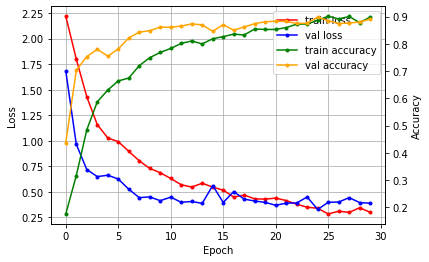

StratifiedKFold fold:2/2
train_N=2500, val_N=2500
fold:2 epoch:1/30 [tra]loss:2.2749 acc:0.1268  [val]loss:2.0559 acc:0.2160  [time]total:14.90sec tra:11.23sec val:3.67sec
fold:2 epoch:2/30 [tra]loss:2.0090 acc:0.2684  [val]loss:1.3063 acc:0.5836  [time]total:14.85sec tra:11.32sec val:3.54sec
fold:2 epoch:3/30 [tra]loss:1.5587 acc:0.4220  [val]loss:0.9692 acc:0.7000  [time]total:15.05sec tra:11.45sec val:3.60sec
fold:2 epoch:4/30 [tra]loss:1.2384 acc:0.5592  [val]loss:0.7403 acc:0.7280  [time]total:14.78sec tra:11.18sec val:3.60sec
fold:2 epoch:5/30 [tra]loss:1.0951 acc:0.6088  [val]loss:0.6880 acc:0.7576  [time]total:14.92sec tra:11.26sec val:3.66sec
fold:2 epoch:6/30 [tra]loss:0.9618 acc:0.6612  [val]loss:0.6016 acc:0.7896  [time]total:15.02sec tra:11.37sec val:3.65sec
fold:2 epoch:7/30 [tra]loss:0.8474 acc:0.6992  [val]loss:0.5186 acc:0.8272  [time]total:14.91sec tra:11.31sec val:3.60sec
fold:2 epoch:8/30 [tra]loss:0.7910 acc:0.7336  [val]loss:0.5353 acc:0.8268  [time]total:14.99sec

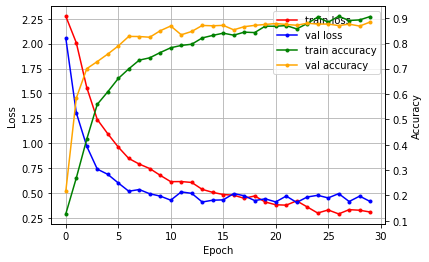

all folds score
total loss:0.401863, accuracy:0.887400
fold1/2 loss:0.388249, accuracy:0.890800
fold2/2 loss:0.415477, accuracy:0.884000

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,475,3,3,0,2,0,2,0,13,2
1,5,476,0,5,3,2,2,7,0,0
2,1,1,484,0,0,1,0,0,0,13
3,0,14,0,422,12,39,2,10,0,1
4,0,14,0,12,438,14,15,7,0,0
5,0,9,0,23,16,419,27,6,0,0
6,4,2,0,8,36,44,400,4,1,1
7,1,30,1,28,10,18,2,410,0,0
8,13,2,0,0,0,1,1,0,476,7


In [32]:
train_models, train_model_paths = train()

# Test

In [36]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.STL10(root="./", split="test", download=True, transform=None)
    test_Xs = test_ds.data.astype(np.uint8).transpose(0, 2, 3, 1)
    test_ys = np.array(test_ds.labels)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.9056 (7245 / 8000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,759,6,9,0,0,0,1,0,20,5
1,3,770,0,14,4,3,2,3,1,0
2,3,0,778,0,1,0,0,0,2,16
3,0,23,0,681,24,51,2,19,0,0
4,2,15,2,22,720,20,11,8,0,0
5,3,17,1,38,16,689,21,15,0,0
6,3,18,4,7,41,59,655,10,1,2
7,0,26,0,22,11,19,2,720,0,0
8,16,2,2,1,0,0,0,0,769,10


In [37]:
# display layer name

model = train_models[0]

for name, module in model.named_modules():
    print(name)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


In [39]:
from collections import OrderedDict

fmap_pool = OrderedDict()
grad_pool = OrderedDict()

def forward_hook(key):
    def forward_hook_(module, input, output):
        # Save featuremaps
        fmap_pool[key] = output.detach()

    return forward_hook_

def backward_hook(key):
    def backward_hook_(module, grad_in, grad_out):
        # Save the gradients correspond to the featuremaps
        grad_pool[key] = grad_out[0].detach()

    return backward_hook_

# If any candidates are not specified, the hook is registered to all the layers.
for name, module in model.named_modules():
    module.register_forward_hook(forward_hook(name))
    module.register_backward_hook(backward_hook(name))

In [50]:
target_layer_name = "features.30"

for name, module in model.named_modules():
    if name == target_layer_name:
        print('target:', name)
        target_layer = module

target: features.30


In [61]:
import matplotlib.cm as cm

Class_labels =  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
class_num = len(Class_labels)

def grad_cam(model, x):
    # forward network
    logit = model(x)
    preds = F.softmax(logit, dim=1).detach().cpu().numpy()

    raw_image = x[0].cpu().numpy().astype(np.float32).transpose(1, 2, 0) * 0.5 + 0.5
    raw_image -= raw_image.min()
    raw_image /= raw_image.max()

    plt.figure(figsize=(20, 4))
    plt.subplot(1, class_num + 1, 1)
    plt.imshow(raw_image)
    plt.title('input')

    cmaps = np.zeros([class_num, IN_HEIGHT, IN_WIDTH, 3], dtype=np.float32)

    with torch.no_grad():
        for i, class_label in enumerate(Class_labels):
            # set one-hot class activity
            class_index = torch.zeros(preds.shape).to(device)
            class_index[:, i] = 1

            logit.backward(gradient=class_index, retain_graph=True)
            
            #target_layer_output = target_layer.forward(x)
            fmaps = fmap_pool[target_layer_name]
            grads = grad_pool[target_layer_name]
            weights = F.adaptive_avg_pool2d(grads, 1)

            gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)

            gcam = F.interpolate(gcam, [IN_HEIGHT, IN_WIDTH], mode="bilinear", align_corners=False)

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            # gcam -= gcam.min(dim=1, keepdim=True)[0]
            # gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam = gcam.view(B, C, H, W)

            gcam = gcam.cpu().numpy()[0, 0]
            cmap = cm.jet(gcam)[..., :3]
            cmaps[i] = cmap

        # normalize inter class
        cmaps -= cmaps.min()
        cmaps /= cmaps.max()

    for i, class_label in enumerate(Class_labels): 
        gcam = (cmaps[i].astype(np.float) + raw_image.astype(np.float)) / 2
    
        plt.subplot(1, class_num + 1, i + 2)
        plt.imshow(gcam)
        plt.title('{} :{:.4f}'.format(class_label, preds[0, i]))

    plt.show()

Files already downloaded and verified


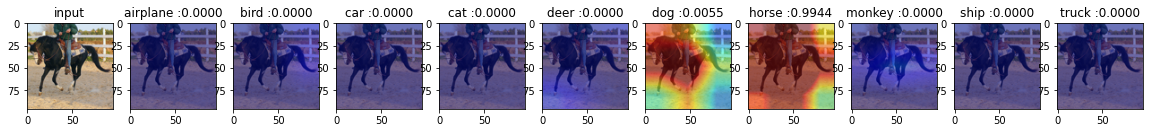

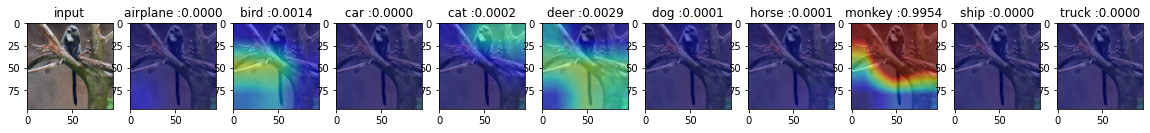

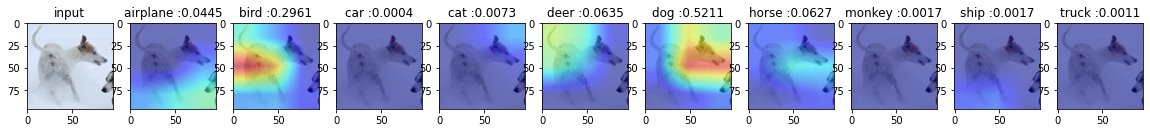

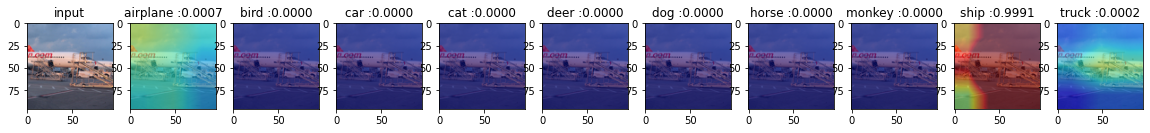

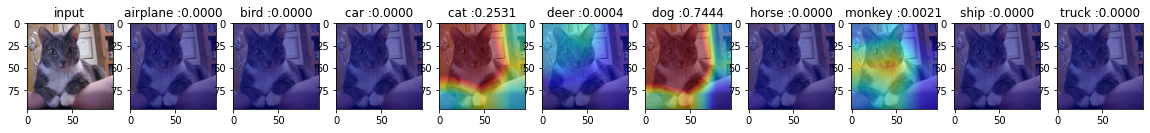

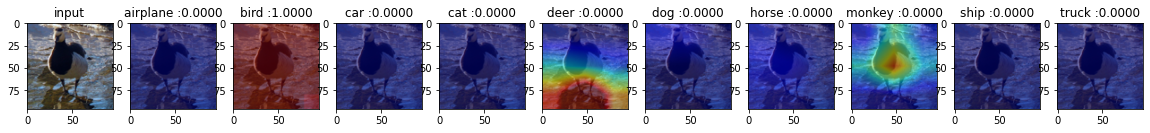

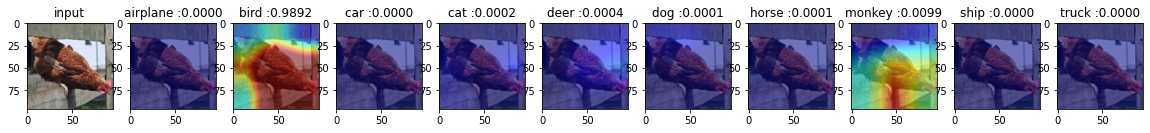

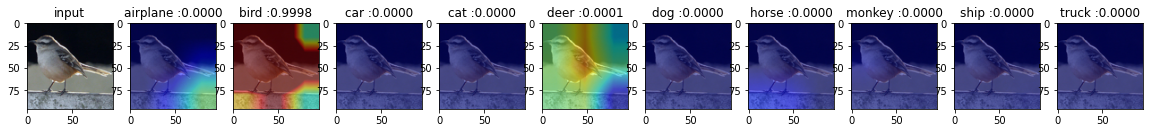

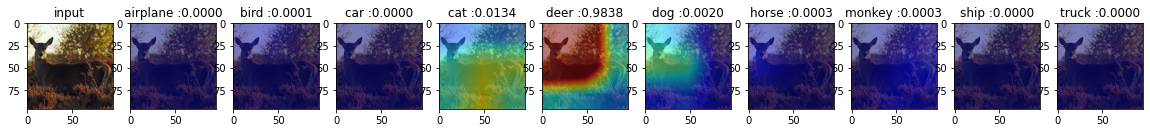

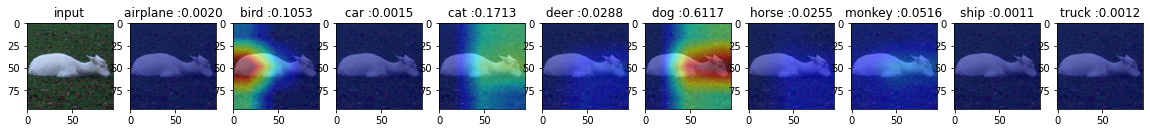

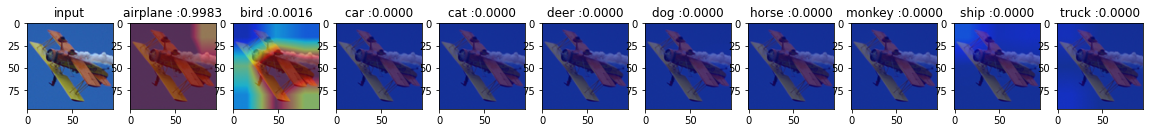

In [62]:
test_ds = torchvision.datasets.STL10(root="./", split="test", download=True, transform=None)
test_Xs = test_ds.data.astype(np.uint8).transpose(0, 2, 3, 1)
test_ys = np.array(test_ds.labels)

dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
dataloader_test = DataLoader(dataset_test, batch_size=1, num_workers=4, shuffle=False, pin_memory=True)

for step, batch in enumerate(dataloader_test):
    Xs = batch[0].to(device) # image
    grad_cam(model, Xs)

    if step >= 10:
        break